In [50]:
# Notebook 4 — Rolling Recalibration & Stability Check

# ================================================
# 1️⃣ SETUP & DATA
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import os

# --- Config ---
WINDOW = 24 * 15   # 336 heures ≈ 2 semaines
ADF_ALPHA = 0.05  # significance threshold

PAIRS_PATH = "../data/processed/pair_selection/pairs_results.parquet"  # Résultats de la partie 2
PRICES_PATH = "../data/processed/close_1h.parquet"  # Historique des prix (même base)
OUTPUT_DIR = "../data/processed/backtest_results"

In [63]:
# --- Example data ---
# You can replace with your actual data paths
# Chargement des prix
prices = pd.read_parquet(PRICES_PATH)
prices.index = pd.to_datetime(prices.index, utc=True, errors="coerce")
prices = prices.sort_index().ffill().bfill()
print(f"✅ Données de prix chargées : {prices.shape[0]} observations, {prices.shape[1]} tickers.")

data = np.log(prices)

print(f"Data loaded: {data.shape} | Period: {data.index.min()} → {data.index.max()}")


✅ Données de prix chargées : 3494 observations, 9 tickers.
Data loaded: (3494, 9) | Period: 2023-10-18 13:30:00+00:00 → 2025-10-17 19:30:00+00:00


C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\4280566345.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas.append(model.params[1])
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\4280566345.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas.append(model.params[1])
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\4280566345.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas.append(model.params[1])
C:\U

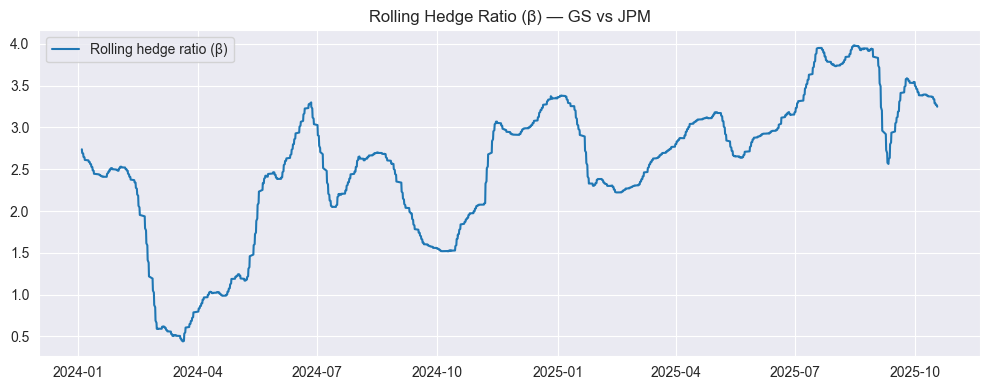

In [52]:
# ================================================
# 2️⃣ ROLLING HEDGE RATIO
# ================================================
def rolling_hedge_ratio(y, x, window=120):
    betas = []
    for i in range(window, len(y)):
        y_win = y[i-window:i]
        x_win = sm.add_constant(x[i-window:i])
        model = sm.OLS(y_win, x_win).fit()
        betas.append(model.params[1])
    return pd.Series(betas, index=y.index[window:])

y = prices['GS']
x = prices['JPM']
hedge_ratio = rolling_hedge_ratio(y, x, window=WINDOW)

plt.figure(figsize=(10,4))
plt.plot(hedge_ratio, label='Rolling hedge ratio (β)')
plt.title('Rolling Hedge Ratio (β) — GS vs JPM')
plt.legend(); plt.tight_layout()
plt.show()


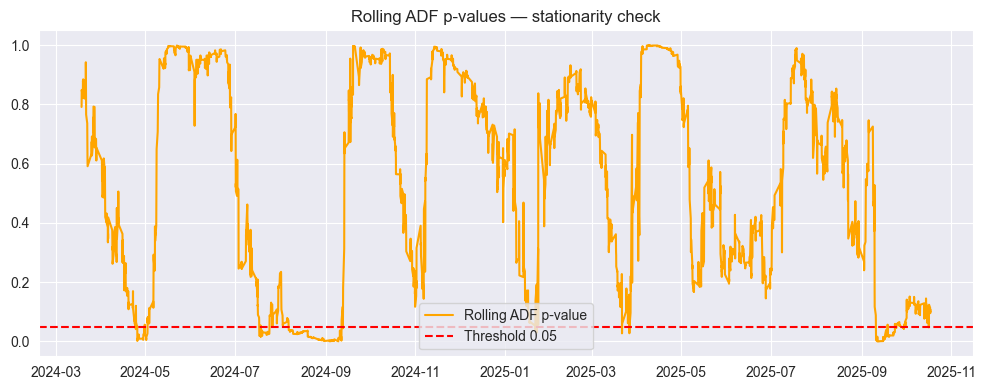

In [53]:
# ================================================
# 3️⃣ ROLLING ADF TEST (STATIONARITY)
# ================================================
def rolling_adf_test(spread, window=120):
    pvals = []
    for i in range(window, len(spread)):
        sample = spread[i - window:i].dropna()
        if sample.isnull().any() or len(sample) < 10:
            pvals.append(np.nan)
            continue
        try:
            pval = adfuller(sample)[1]
        except Exception:
            pval = np.nan
        pvals.append(pval)
    return pd.Series(pvals, index=spread.index[window:])


# compute rolling spread

spread = y - hedge_ratio.reindex(y.index, method='ffill') * x
spread = spread.replace([np.inf, -np.inf], np.nan).dropna()
pvals = rolling_adf_test(spread, window=WINDOW)

plt.figure(figsize=(10,4))
plt.plot(pvals, label='Rolling ADF p-value', color='orange')
plt.axhline(ADF_ALPHA, color='red', linestyle='--', label='Threshold 0.05')
plt.title('Rolling ADF p-values — stationarity check')
plt.legend(); plt.tight_layout()
plt.show()

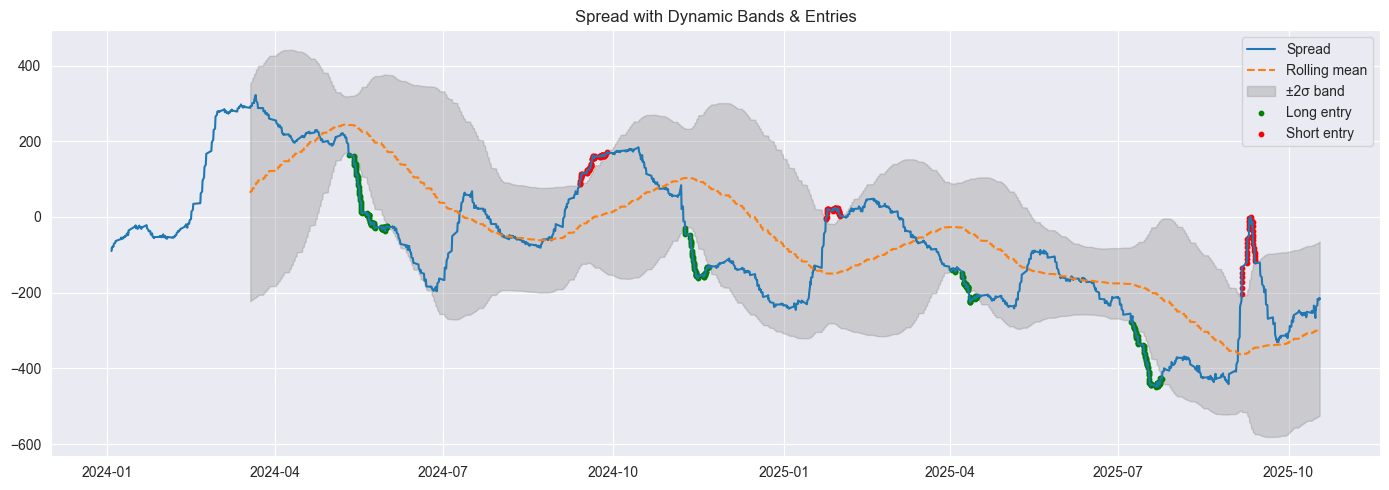

In [54]:
# ================================================
# 4️⃣ DYNAMIC Z-SCORE & SIGNALS
# ================================================
spread_ma = spread.rolling(WINDOW).mean()
spread_std = spread.rolling(WINDOW).std()
zscore = (spread - spread_ma) / spread_std

entry_long = zscore < -2
entry_short = zscore > 2
exit = (zscore < 0.5) & (zscore > -0.5)

plt.figure(figsize=(14,5))
plt.plot(spread, label='Spread')
plt.plot(spread_ma, label='Rolling mean', linestyle='--')
plt.fill_between(spread.index, spread_ma - 2*spread_std, spread_ma + 2*spread_std,
                 color='gray', alpha=0.3, label='±2σ band')
plt.scatter(spread.index[entry_long], spread[entry_long], color='green', label='Long entry', s=10)
plt.scatter(spread.index[entry_short], spread[entry_short], color='red', label='Short entry', s=10)
plt.title('Spread with Dynamic Bands & Entries')
plt.legend(); plt.tight_layout()
plt.show()

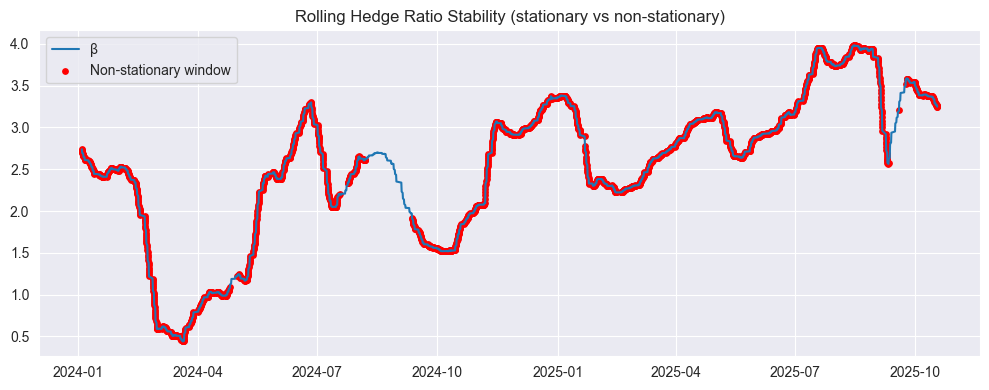

In [55]:

# ================================================
# 5️⃣ AUTO-RECALIBRATION LOGIC
# ================================================
stability = pd.DataFrame({
    'hedge_ratio': hedge_ratio,
    'p_value': pvals
})
stability['is_stationary'] = stability['p_value'] < ADF_ALPHA
stability['status'] = np.where(stability['is_stationary'], 'STABLE', 'UNSTABLE')

# visualize stability
plt.figure(figsize=(10,4))
plt.plot(stability.index, stability['hedge_ratio'], label='β')
plt.scatter(stability.index[stability['status']=='UNSTABLE'],
            stability.loc[stability['status']=='UNSTABLE','hedge_ratio'],
            color='red', label='Non-stationary window', s=15)
plt.title('Rolling Hedge Ratio Stability (stationary vs non-stationary)')
plt.legend(); plt.tight_layout()
plt.show()

In [56]:
# ================================================
# 6️⃣ EXPORT RESULTS
# ================================================
out_dir = 'data/rolling'
os.makedirs(out_dir, exist_ok=True)

stability.to_csv(f'{out_dir}/hedge_adf_results.csv')
zscore.to_csv(f'{out_dir}/zscore_dynamic.csv', header=['zscore'])
print(f"Saved rolling metrics to {out_dir}/")

# ================================================
# 7️⃣ CONCLUSION
# ================================================
print("✅ Rolling recalibration complete. Check the exported CSVs and plots for stability analysis.")


Saved rolling metrics to data/rolling/
✅ Rolling recalibration complete. Check the exported CSVs and plots for stability analysis.


              Strategy   Sharpe     MaxDD  FinalPnL  Trades (approx)  Active % (ADF)
              Static β 2.935605 23.461326 85.541511               54             NaN
Rolling β (smooth+ADF) 0.000000  0.000000  0.000000                0        9.473383


C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\4066167327.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


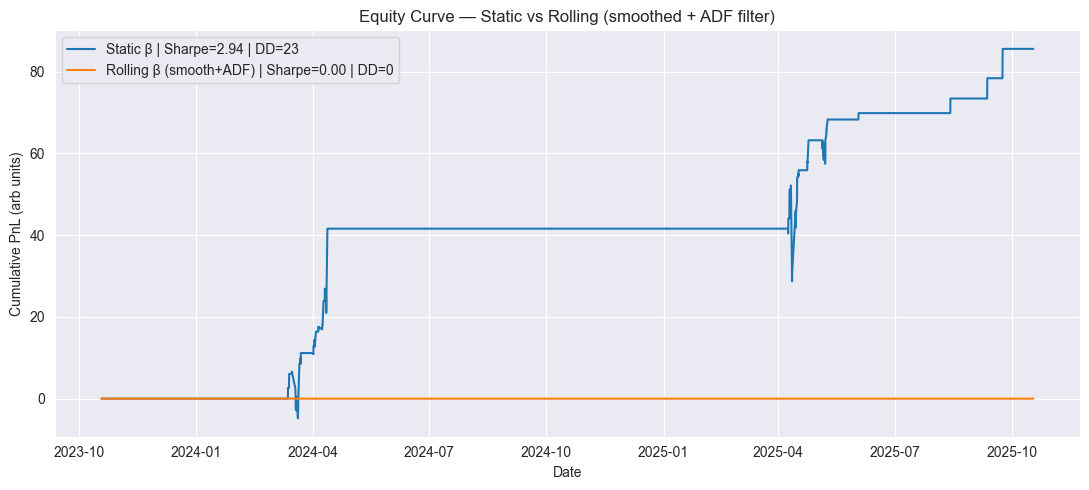

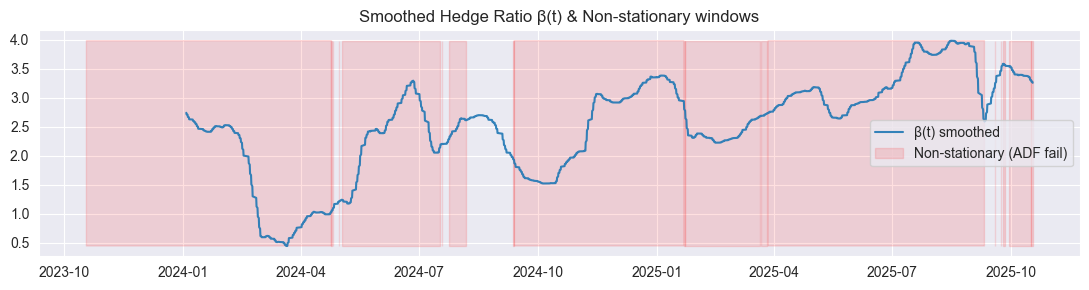

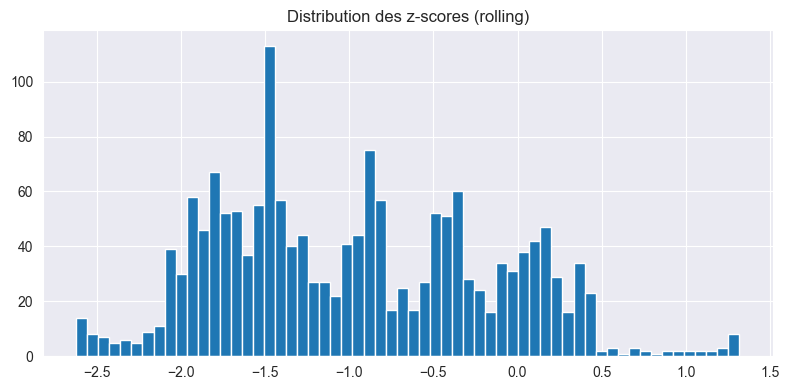

In [57]:
# ================================================
# 8️⃣ BACKTEST ROBUSTE : Static vs Rolling (lissé + filtre ADF)
# ================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ---------- Paramètres (à ajuster si besoin) ----------
ENTRY_Z = 2.0         # seuil d'entrée (|z| > ENTRY_Z)
EXIT_Z = 0.5          # bande de sortie (|z| < EXIT_Z)
TC_BP = 0.0           # coûts de transac en bp par changement de position (ex: 0.5 => 0.5bp)
ANNUALIZE = np.sqrt(252*24)  # données horaires; mets np.sqrt(252) si daily
WINDOW_LONG = max(WINDOW, 24*60)  # fenêtre mini pour rolling metrics (~60j si horaire)
ADF_THR = 0.05        # on ne trade que si p-value ADF < 5%

# ---------- Helpers ----------
def compute_stats(pnl):
    pnl = pnl.dropna()
    vol = pnl.std()
    sharpe = (ANNUALIZE * pnl.mean() / vol) if vol and vol > 0 else 0.0
    eq = pnl.cumsum()
    dd = (eq.cummax() - eq).max()
    return float(sharpe), float(dd), float(eq.iloc[-1] if len(eq) else 0.0)

def apply_tc(pnl, pos, tc_bp=0.0):
    """Applique coûts de transac en bp lors des changements de position."""
    if tc_bp <= 0:
        return pnl
    # coût par changement de signe/valeur (position t vs t-1)
    pos_shift = pos.shift(1).fillna(0)
    turns = (pos != pos_shift).astype(int)
    # coût ≈ bp * notionnel * 1e-4, ici on l'impute en 'pnl' unitaire (ad-hoc backtest)
    # on suppose notionnel=1 par point de spread; ajuste selon ton moteur si besoin.
    tc = turns * (tc_bp * 1e-4)
    return pnl - tc

# ---------- Backtest statique ----------
def backtest_static(y, x, entry_z=ENTRY_Z, exit_z=EXIT_Z, tc_bp=TC_BP):
    model = sm.OLS(y, sm.add_constant(x)).fit()
    beta = model.params[1]

    spread = y - beta * x
    mu, sigma = spread.mean(), spread.std()
    z = (spread - mu) / sigma

    # signaux (un pas plus tard pour éviter tout leakage)
    pos = np.where(z > entry_z, -1, np.where(z < -entry_z, 1, 0))
    pos = pd.Series(pos, index=z.index).shift(1).fillna(0)

    # sortie soft : on peut réduire l'expo quand |z| < EXIT_Z
    in_exit = (z.abs() < exit_z).astype(int)
    pos = np.where(in_exit, pos * 0.0, pos)
    pos = pd.Series(pos, index=z.index)

    pnl = (spread.diff() * pos).fillna(0)
    pnl = apply_tc(pnl, pos, tc_bp)
    equity = pnl.cumsum()
    return equity, pnl, pos, spread, z

# ---------- Backtest rolling (β lissé + filtre ADF + alignements) ----------
def backtest_rolling(y, x,
                     hedge_series,        # β(t) déjà calculé plus haut
                     pvals_series,        # p-values ADF rolling (même index)
                     entry_z=ENTRY_Z, exit_z=EXIT_Z,
                     tc_bp=TC_BP,
                     win=WINDOW_LONG, adf_thr=ADF_THR,
                     smooth_span=5):      # lissage exp du β
    # alignements & lissage
    beta = hedge_series.ewm(span=smooth_span, min_periods=1).mean()
    beta = beta.shift(1).reindex(y.index, method='ffill')

    # spread avec β(t) lissé
    spread = y - beta * x

    # rolling stats (alignées, sans fuite)
    mu = spread.rolling(win).mean().shift(1)
    sd = spread.rolling(win).std().shift(1)
    z = ((spread - mu) / sd).replace([np.inf, -np.inf], np.nan)

    # filtre ADF : actif seulement si stationnaire
    active = pvals_series.reindex(y.index, method='ffill') < adf_thr
    active = active.fillna(False).astype(int)

    # signaux (un pas plus tard)
    raw_pos = np.where(z > entry_z, -1, np.where(z < -entry_z, 1, 0))
    pos = pd.Series(raw_pos, index=z.index).shift(1).fillna(0)

    # sortie soft
    in_exit = (z.abs() < exit_z).astype(int)
    pos = np.where(in_exit, pos * 0.0, pos)
    pos = pd.Series(pos, index=z.index)

    # masque d'activité (pas de trade si non stationnaire)
    pos = pos * active

    pnl = (spread.diff() * pos).fillna(0)
    pnl = apply_tc(pnl, pos, tc_bp)
    equity = pnl.cumsum()
    return equity, pnl, pos, spread, z, beta, active

# ---------- Exécution (sur la paire y=prices['GS'], x=prices['JPM'] définies plus haut) ----------
equity_static, pnl_static, pos_static, spread_static, z_static = backtest_static(y, x)

# pvals (ADF) calculées plus haut: 'pvals'
# sinon, sécurise:
pvals_safe = pvals.copy() if 'pvals' in globals() else pd.Series(index=y.index, data=np.nan)

equity_roll, pnl_roll, pos_roll, spread_roll, z_roll, beta_smooth, active_mask = backtest_rolling(
    y, x, hedge_ratio, pvals_safe,
    entry_z=ENTRY_Z, exit_z=EXIT_Z,
    tc_bp=TC_BP, win=WINDOW_LONG, adf_thr=ADF_THR, smooth_span=5
)

# ---------- Métriques ----------
sh_s, dd_s, pnl_s = compute_stats(pnl_static)
sh_r, dd_r, pnl_r = compute_stats(pnl_roll)

comp = pd.DataFrame({
    'Strategy': ['Static β', 'Rolling β (smooth+ADF)'],
    'Sharpe': [sh_s, sh_r],
    'MaxDD': [dd_s, dd_r],
    'FinalPnL': [pnl_s, pnl_r],
    'Trades (approx)': [int((pos_static.diff().abs()>0).sum()), int((pos_roll.diff().abs()>0).sum())],
    'Active % (ADF)': [np.nan, float(100*active_mask.mean())]
})
print(comp.to_string(index=False))

# ---------- Plots ----------
plt.figure(figsize=(11,5))
plt.plot(equity_static, label=f'Static β | Sharpe={sh_s:.2f} | DD={dd_s:.0f}')
plt.plot(equity_roll,   label=f'Rolling β (smooth+ADF) | Sharpe={sh_r:.2f} | DD={dd_r:.0f}')
plt.title('Equity Curve — Static vs Rolling (smoothed + ADF filter)')
plt.xlabel('Date'); plt.ylabel('Cumulative PnL (arb units)')
plt.legend(); plt.tight_layout(); plt.show()

# β(t) lissé + périodes inactives
plt.figure(figsize=(11,3))
plt.plot(beta_smooth, label='β(t) smoothed', alpha=0.9)
plt.fill_between(beta_smooth.index, beta_smooth.min(), beta_smooth.max(),
                 where=~active_mask.astype(bool), color='red', alpha=0.12, label='Non-stationary (ADF fail)')
plt.title('Smoothed Hedge Ratio β(t) & Non-stationary windows')
plt.legend(); plt.tight_layout(); plt.show()

# Distribution des z-scores (rolling)
plt.figure(figsize=(8,4))
z_roll.dropna().hist(bins=60)
plt.title('Distribution des z-scores (rolling)')
plt.tight_layout(); plt.show()


                          Strategy    Sharpe      MaxDD    FinalPnL  Trades (approx)  Active % (ADF)
                          Static β  2.935605  23.461326   85.541511               54             NaN
Rolling β (quantiles + ADF smooth) -8.140457 225.931849 -224.350690               10        12.76474


C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\1589788163.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pvals_safe = pvals_safe.interpolate().fillna(method='bfill').fillna(method='ffill')


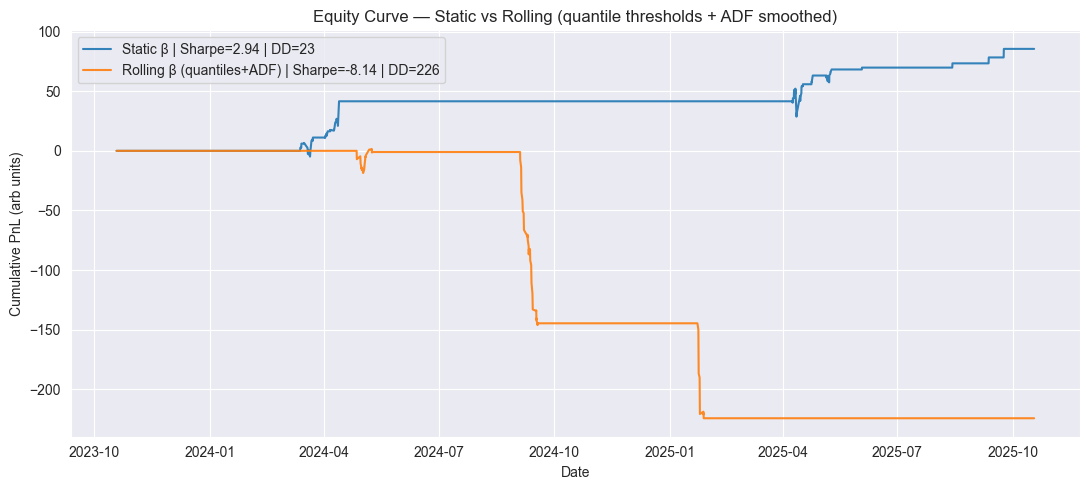

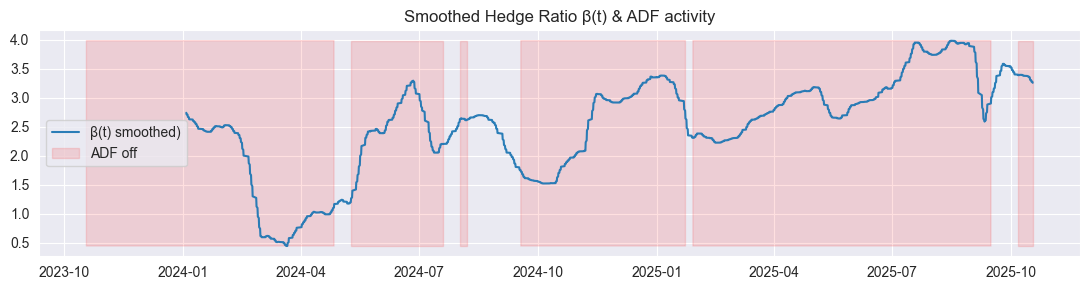

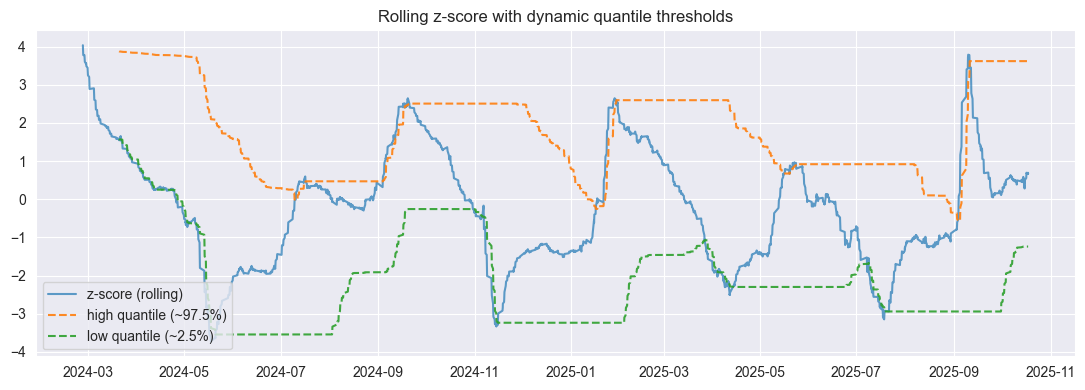

Active% (ADF smoothed): 12.8% | Signals above/below quantiles: 678 | Trades(approx): 10


In [58]:
# ============================================================
# 9️⃣ BACKTEST ROLLING — ADF lissé + continuité + seuils quantiles
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ---------- Params ----------
ANNUALIZE = np.sqrt(252*24)   # données 1H (si daily: np.sqrt(252))
WINDOW_LONG = max(24*15, WINDOW)  # stats rolling pour z-score (>= ~1.5 mois)
SMOOTH_BETA_SPAN = 5          # lissage exp de β(t)
ADF_THR = 0.10                # seuil ADF (plus tolérant que 0.05)
SMOOTH_P = 24                 # lissage (médiane) des p-values sur 24h
MIN_ACTIVE_IN_24H = 12        # au moins 12h actives (ADF ok) sur toute fenêtre de 24h
QWIN = 24*15                  # fenêtre quantiles pour seuils (≈ 1 mois)
TC_BP = 0.0                   # coûts en bp par changement de position (0=off)

# ---------- Helpers ----------
def compute_stats(pnl, annualize=ANNUALIZE):
    pnl = pnl.dropna()
    vol = pnl.std()
    sharpe = (annualize * pnl.mean() / vol) if vol and vol > 0 else 0.0
    eq = pnl.cumsum()
    dd = (eq.cummax() - eq).max()
    return float(sharpe), float(dd), float(eq.iloc[-1] if len(eq) else 0.0)

def apply_tc(pnl, pos, tc_bp=0.0):
    if tc_bp <= 0:
        return pnl
    turns = (pos != pos.shift(1).fillna(0)).astype(int)
    return pnl - turns * (tc_bp * 1e-4)

# ---------- Sécurisation des inputs (y, x, hedge_ratio, pvals) ----------
assert 'y' in globals() and 'x' in globals(), "Assure-toi que y et x (log-prices) sont définis plus haut."
assert 'hedge_ratio' in globals(), "Assure-toi que hedge_ratio (β rolling) est calculé plus haut."

# pvals peut ne pas exister si tu n'as pas fait la section ADF : on fallback sur 'actif partout'
if 'pvals' in globals():
    pvals_safe = pvals.copy().reindex(y.index)
    pvals_safe = pvals_safe.interpolate().fillna(method='bfill').fillna(method='ffill')
    pvals_smooth = pvals_safe.rolling(SMOOTH_P, min_periods=1).median()
    active_raw = (pvals_smooth < ADF_THR).astype(int)
    active = (active_raw.rolling(24, min_periods=1).sum() >= MIN_ACTIVE_IN_24H).astype(int)
else:
    active = pd.Series(1, index=y.index)  # pas de filtre ADF

# ---------- β(t) lissé + aligné (pas de fuite d'info) ----------
beta_smooth = hedge_ratio.ewm(span=SMOOTH_BETA_SPAN, min_periods=1).mean()
beta_smooth = beta_smooth.shift(1).reindex(y.index, method='ffill')

# ---------- Spread & z-score rolling (alignés) ----------
spread_roll = y - beta_smooth * x
mu = spread_roll.rolling(WINDOW_LONG, min_periods=int(WINDOW_LONG*0.7)).mean().shift(1)
sd = spread_roll.rolling(WINDOW_LONG, min_periods=int(WINDOW_LONG*0.7)).std().shift(1)
sd = sd.replace(0, np.nan)
z_roll = ((spread_roll - mu) / (sd + 1e-8)).replace([np.inf, -np.inf], np.nan)

# ---------- Seuils dynamiques par quantiles (évite "±2σ" trop haut) ----------
hi = z_roll.rolling(QWIN, min_periods=max(5, QWIN//3)).quantile(0.975).shift(1)
lo = z_roll.rolling(QWIN, min_periods=max(5, QWIN//3)).quantile(0.025).shift(1)

# ---------- Positions (quantiles) + masque d'activité ADF ----------
pos_q = np.where(z_roll > hi, -1, np.where(z_roll < lo, 1, 0))
pos_q = pd.Series(pos_q, index=z_roll.index).shift(1).fillna(0)
pos_q = pos_q * active  # on ne trade que quand stationnaire

# ---------- PnL & equity (avec coûts éventuels) ----------
pnl_q = (spread_roll.diff() * pos_q).fillna(0)
pnl_q = apply_tc(pnl_q, pos_q, tc_bp=TC_BP)
equity_q = pnl_q.cumsum()

# ---------- Baseline "statique" (si pas déjà calculée) ----------
if 'equity_static' not in globals() or 'pnl_static' not in globals():
    model_stat = sm.OLS(y, sm.add_constant(x)).fit()
    beta_stat = model_stat.params[1]
    spread_stat = y - beta_stat * x
    z_stat = (spread_stat - spread_stat.mean()) / spread_stat.std()
    pos_stat = np.where(z_stat > 2, -1, np.where(z_stat < -2, 1, 0))
    pos_stat = pd.Series(pos_stat, index=z_stat.index).shift(1).fillna(0)
    pnl_static = (spread_stat.diff() * pos_stat).fillna(0)
    equity_static = pnl_static.cumsum()

# ---------- Metrics ----------
sh_s, dd_s, pnl_s = compute_stats(pnl_static)
sh_q, dd_q, pnl_qf = compute_stats(pnl_q)

comp_q = pd.DataFrame({
    'Strategy': ['Static β', 'Rolling β (quantiles + ADF smooth)'],
    'Sharpe': [sh_s, sh_q],
    'MaxDD': [dd_s, dd_q],
    'FinalPnL': [pnl_s, pnl_qf],
    'Trades (approx)': [int((pos_static.diff().abs()>0).sum()) if 'pos_static' in globals() else np.nan,
                        int((pos_q.diff().abs()>0).sum())],
    'Active % (ADF)': [np.nan, float(100*pd.Series(active, index=z_roll.index).mean())]
})
print(comp_q.to_string(index=False))

# ---------- Plots ----------
plt.figure(figsize=(11,5))
plt.plot(equity_static, label=f'Static β | Sharpe={sh_s:.2f} | DD={dd_s:.0f}', alpha=0.9)
plt.plot(equity_q,      label=f'Rolling β (quantiles+ADF) | Sharpe={sh_q:.2f} | DD={dd_q:.0f}', alpha=0.9)
plt.title('Equity Curve — Static vs Rolling (quantile thresholds + ADF smoothed)')
plt.xlabel('Date'); plt.ylabel('Cumulative PnL (arb units)')
plt.legend(); plt.tight_layout(); plt.show()

# β(t) lissé + zones ADF off
plt.figure(figsize=(11,3))
plt.plot(beta_smooth, label='β(t) smoothed)', alpha=0.95)
if 'pvals' in globals():
    plt.fill_between(beta_smooth.index, beta_smooth.min(), beta_smooth.max(),
                     where=(active==0), color='red', alpha=0.12, label='ADF off')
plt.title('Smoothed Hedge Ratio β(t) & ADF activity')
plt.legend(); plt.tight_layout(); plt.show()

# Seuils quantiles vs z-score
plt.figure(figsize=(11,4))
plt.plot(z_roll, label='z-score (rolling)', alpha=0.7)
plt.plot(hi, '--', label='high quantile (~97.5%)', alpha=0.9)
plt.plot(lo, '--', label='low quantile (~2.5%)',  alpha=0.9)
plt.title('Rolling z-score with dynamic quantile thresholds')
plt.legend(); plt.tight_layout(); plt.show()

# Quelques indicateurs utiles
active_pct = float(100*pd.Series(active, index=z_roll.index).mean())
signals_cnt = int(((z_roll > hi) | (z_roll < lo)).sum())
print(f"Active% (ADF smoothed): {active_pct:.1f}% | Signals above/below quantiles: {signals_cnt} | Trades(approx): {int((pos_q.diff().abs()>0).sum())}")


C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3352612775.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = y.resample('M').last().index
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3352612775.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_by_month[t] = sm.OLS(yy, xx).fit().params[1]
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3352612775.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_by_month[t] = sm.OLS(yy, xx).fit().params[1]
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3352612775.py:27: FutureWarning: Se

Static(clean)  → Sharpe=0.87 | MaxDD=35 | FinalPnL=60.8
Walk-Forward   → Sharpe=0.98 | MaxDD=17 | FinalPnL=58.8


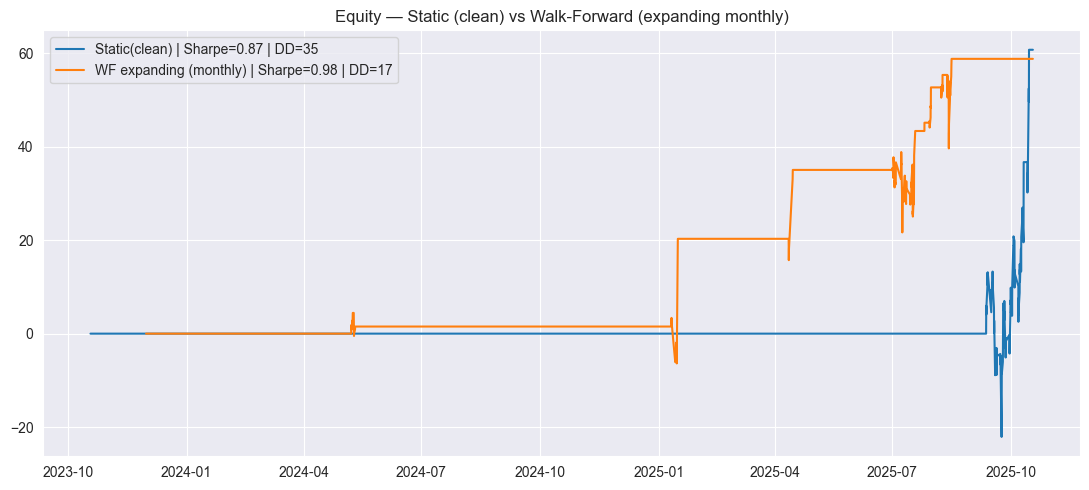

In [60]:
# ============================================
# Walk-Forward (Expanding) Monthly Hedge Ratio
# ============================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Hypothèses: y, x (log-prices) déjà définis plus haut
ANNUALIZE = np.sqrt(252*6.5)  # horaire US ~6.5h/j
WIN_Z = 24*45                  # fenetre pour mu/sigma du spread (rolling pour z-score)
EXIT_Z = 0.5

# 1) Dates de rebal mensuel (utilisation de la dernière barre de chaque mois)
month_ends = y.resample('M').last().index

# 2) Calcule beta(t) en expanding: à chaque fin de mois m, fit OLS sur [start .. m]
beta_by_month = {}
for t in month_ends:
    hist_y = y.loc[:t].dropna()
    hist_x = x.loc[:t].dropna()
    common = hist_y.index.intersection(hist_x.index)
    if len(common) < 200:  # minimum d'historique
        continue
    yy = hist_y.loc[common]
    xx = sm.add_constant(hist_x.loc[common])
    beta_by_month[t] = sm.OLS(yy, xx).fit().params[1]

# 3) Série β(t) mensuelle → forward-fill sur l’horaire, et décale d’1 barre (pas de fuite)
beta_expanding = pd.Series(beta_by_month).sort_index()
beta_expanding = beta_expanding.reindex(y.index, method='ffill').shift(1)

# 4) Spread & z-score rolling (alignés)
spread_wf = (y - beta_expanding * x).dropna()
mu = spread_wf.rolling(WIN_Z, min_periods=int(WIN_Z*0.7)).mean().shift(1)
sd = spread_wf.rolling(WIN_Z, min_periods=int(WIN_Z*0.7)).std().shift(1)
z  = ((spread_wf - mu) / (sd + 1e-8)).replace([np.inf, -np.inf], np.nan)

# Seuils fixes (classiques). Tu peux remettre ±2/±0.5 pour comparer
ENTRY_Z_HIGH = 2.0
ENTRY_Z_LOW  = -2.0

enter_long  = (z < ENTRY_Z_LOW)
enter_short = (z > ENTRY_Z_HIGH)
exit_all    = (z.abs() < EXIT_Z)

# Machine à état: on n'entre que si pas déjà en position; on sort quand exit
pos = pd.Series(0.0, index=z.index)
pos[enter_long] = 1.0
pos[enter_short] = -1.0
pos = pos.ffill().where(~exit_all, 0.0)   # conserve la position jusqu’à la sortie
pos = pos.shift(1).fillna(0.0)            # exécution au bar suivant


# PnL
pnl_wf = (spread_wf.diff() * pos).fillna(0)
eq_wf  = pnl_wf.cumsum()

# Baseline statique propre (calibrée sur le 1er mois seulement pour éviter look-ahead)
first_month = month_ends.min()
train_end = first_month  # calibration initiale sur ~1 mois; tu peux élargir
yy0 = y.loc[:train_end]; xx0 = sm.add_constant(x.loc[:train_end])
beta0 = sm.OLS(yy0, xx0).fit().params[1] if len(yy0)>50 else beta_expanding.dropna().iloc[0]

spread_stat_clean = (y - beta0 * x).dropna()
z_stat = (spread_stat_clean - spread_stat_clean.mean()) / (spread_stat_clean.std() + 1e-8)
pos_s = np.where(z_stat > 2, -1, np.where(z_stat < -2, 1, 0))
pos_s = pd.Series(pos_s, index=z_stat.index).shift(1).fillna(0)
pnl_stat = (spread_stat_clean.diff() * pos_s).fillna(0)
eq_stat = pnl_stat.cumsum()

# Métriques
def metrics(pnl, ann=ANNUALIZE):
    pnl = pnl.dropna()
    vol = pnl.std()
    sh = (ann * pnl.mean() / vol) if vol and vol>0 else 0.0
    dd = (pnl.cumsum().cummax() - pnl.cumsum()).max()
    return sh, dd, pnl.cumsum().iloc[-1] if len(pnl)>0 else 0.0

sh_stat, dd_stat, pnl_stat_f = metrics(pnl_stat)
sh_wf,   dd_wf,   pnl_wf_f  = metrics(pnl_wf)

print(f"Static(clean)  → Sharpe={sh_stat:.2f} | MaxDD={dd_stat:.0f} | FinalPnL={pnl_stat_f:.1f}")
print(f"Walk-Forward   → Sharpe={sh_wf:.2f} | MaxDD={dd_wf:.0f} | FinalPnL={pnl_wf_f:.1f}")

# Plots
plt.figure(figsize=(11,5))
plt.plot(eq_stat, label=f"Static(clean) | Sharpe={sh_stat:.2f} | DD={dd_stat:.0f}")
plt.plot(eq_wf,   label=f"WF expanding (monthly) | Sharpe={sh_wf:.2f} | DD={dd_wf:.0f}")
plt.title("Equity — Static (clean) vs Walk-Forward (expanding monthly)")
plt.legend(); plt.tight_layout(); plt.show()


→ Backtest WF expanding for GS-JPM


C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = y.resample('M').last().index
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_by_month[t] = sm.OLS(yy, xx).fit().params[1]
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_by_month[t] = sm.OLS(yy, xx).fit().params[1]
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:31: FutureWarning: Se

→ Backtest WF expanding for BK-GS


C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = y.resample('M').last().index
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_by_month[t] = sm.OLS(yy, xx).fit().params[1]
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_by_month[t] = sm.OLS(yy, xx).fit().params[1]
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:31: FutureWarning: Se

→ Backtest WF expanding for JPM-WFC


C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = y.resample('M').last().index
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_by_month[t] = sm.OLS(yy, xx).fit().params[1]
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_by_month[t] = sm.OLS(yy, xx).fit().params[1]
C:\Users\Emile\AppData\Local\Temp\ipykernel_18060\3380690196.py:31: FutureWarning: Se


=== Résumé des performances (2 ans, WF expanding) ===
         Sharpe  MaxDD  FinalPnL  Trades
Pair                                    
GS-JPM     0.95   0.01      0.04       2
BK-GS      0.09   0.14      0.02       4
JPM-WFC   -0.79   0.09     -0.06       3


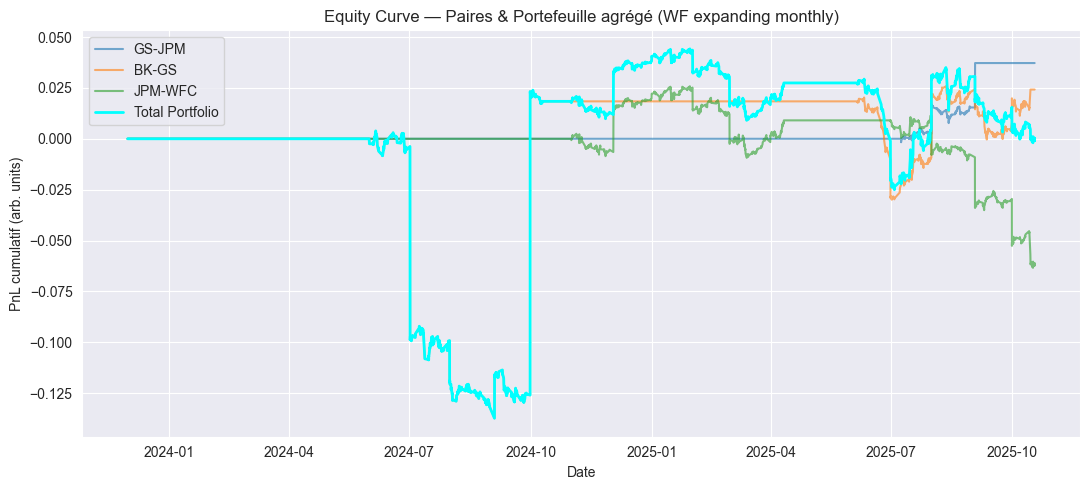

In [64]:
# ============================================================
# 🔁 MULTI-PAIRES — Walk-Forward Expanding Monthly Backtest
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --- paramètres ---
ANNUALIZE = np.sqrt(252*6.5)
WIN_Z = 24*45
EXIT_Z = 0.5
ENTRY_Z_HIGH = 2.0
ENTRY_Z_LOW = -2.0
MIN_HIST = 200    # observations mini avant premier recalibrage

# ============================================================
def backtest_expanding(y, x, pair_name="pair"):
    """Walk-forward expanding OLS recalibrated monthly"""
    month_ends = y.resample('M').last().index
    beta_by_month = {}

    for t in month_ends:
        hist_y = y.loc[:t].dropna()
        hist_x = x.loc[:t].dropna()
        common = hist_y.index.intersection(hist_x.index)
        if len(common) < MIN_HIST:
            continue
        yy = hist_y.loc[common]
        xx = sm.add_constant(hist_x.loc[common])
        beta_by_month[t] = sm.OLS(yy, xx).fit().params[1]

    if not beta_by_month:
        return None

    beta_expanding = pd.Series(beta_by_month).sort_index()
    beta_expanding = beta_expanding.reindex(y.index, method='ffill').shift(1)

    spread = (y - beta_expanding * x).dropna()
    mu = spread.rolling(WIN_Z, min_periods=int(WIN_Z*0.7)).mean().shift(1)
    sd = spread.rolling(WIN_Z, min_periods=int(WIN_Z*0.7)).std().shift(1)
    z = ((spread - mu) / (sd + 1e-8)).replace([np.inf, -np.inf], np.nan)

    enter_long  = (z < ENTRY_Z_LOW)
    enter_short = (z > ENTRY_Z_HIGH)
    exit_all    = (z.abs() < EXIT_Z)

    pos = pd.Series(0.0, index=z.index)
    for i in range(1, len(z)):
        pos.iloc[i] = pos.iloc[i-1]
        if exit_all.iloc[i]:
            pos.iloc[i] = 0.0
        elif pos.iloc[i] == 0.0:
            if enter_long.iloc[i]:
                pos.iloc[i] = 1.0
            elif enter_short.iloc[i]:
                pos.iloc[i] = -1.0
    pos = pos.shift(1).fillna(0.0)

    pnl = (spread.diff() * pos).fillna(0.0)
    equity = pnl.cumsum()

    vol = pnl.std()
    sharpe = (ANNUALIZE * pnl.mean() / vol) if vol and vol > 0 else 0.0
    dd = (equity.cummax() - equity).max()
    final = equity.iloc[-1] if len(equity) else 0.0

    trades = int((pos.diff().abs() > 0).sum())

    res = {
        "pair": pair_name,
        "sharpe": sharpe,
        "max_dd": dd,
        "final_pnl": final,
        "trades": trades,
        "equity": equity,
        "pnl": pnl,
    }
    return res

# ============================================================
# 🔹 CHARGER TES DONNÉES — adapte les chemins selon ton setup
pairs = [
    ("GS", "JPM"),
    ("BK", "GS"),
    ("JPM", "WFC")
]

results = []

for a, b in pairs:
    # Exemple : tu as déjà un DataFrame global "data" avec colonnes ['GS','JPM','BK','WFC']
    y = np.log(data[a].dropna())
    x = np.log(data[b].dropna())
    print(f"→ Backtest WF expanding for {a}-{b}")
    res = backtest_expanding(y, x, f"{a}-{b}")
    if res:
        results.append(res)

# ============================================================
# 🔹 TABLEAU COMPARATIF
df_perf = pd.DataFrame([{
    "Pair": r["pair"],
    "Sharpe": r["sharpe"],
    "MaxDD": r["max_dd"],
    "FinalPnL": r["final_pnl"],
    "Trades": r["trades"]
} for r in results]).set_index("Pair")

print("\n=== Résumé des performances (2 ans, WF expanding) ===")
print(df_perf.round(2))

# ============================================================
# 🔹 ÉQUITY PORTFOLIO AGRÉGÉ (somme des PnL)
equity_portfolio = sum(r["equity"] for r in results)
equity_portfolio -= equity_portfolio.iloc[0]

plt.figure(figsize=(11,5))
for r in results:
    plt.plot(r["equity"], alpha=0.6, label=r["pair"])
plt.plot(equity_portfolio, color='cyan', linewidth=2.0, label="Total Portfolio")
plt.title("Equity Curve — Paires & Portefeuille agrégé (WF expanding monthly)")
plt.xlabel("Date"); plt.ylabel("PnL cumulatif (arb. units)")
plt.legend(); plt.tight_layout(); plt.show()
